# Beat the Books

#### A data science project by Jonathan Sears

### Project Plan
The main goal of this project is to find a way to profit of of sports betting. There are several reasons I want to do this. First I want to make money, I feel like that is pretty self explanatory. Additionally, sports books and casinos always stack the odds in their favor, so I think it would be cool to find a way to beat them at their own game. 

### Approach
I plan on using a couple different approaches to try to beat the books. The first approach is to use an arbitrage strategy. The idea behind the arbitrage strategy is to find 2 different books with different odds on the same game with a big enough gap between them so I can bet on two different outcomes of the game and be guaranteed to win money. This is the safest approach as winning money is guaranteed but it is also the slowest, as finding situations like this is pretty rare. I plan on using webscraping to scrape data from different sports books and then analyzing the data to try to identify arbitrage opportunities. A second approach is plus EV betting. This approach is similar to arbitrage, except it is riskier, as plus EV betting forgoes the hedge bet. Although this approach is riskier in the short run, in the long run it is much more profitable, due to the law of large numbers, assuming we are properly assesing our probability of a bet hitting, we should still see some serious returns. Lastly I plan on using data from past games to try to train a machine learning model to accurately predict the odds of a team winning a game, and use that data to identify plus EV bets. 

### Important Questions
- How can I predict the probability of an NFL game outcome more accurately than a sports book?
- What variables are most predictive of a game outcome?
- How can I scrape the web for gambling odds every day?
- How can I stay up to date on recent odds changes?
- How can I flag discrepancies between the odds of a particular game?

# Some Important Math

### Expected Value and the Law of Large Numbers
There is some important math we will need to have a strong understanding of during this project. The plus EV strategy relies on identifying bets with positive expected values, so it's important to have a strong understanding of what expected values are. The expected value of a bet will be:

    EV = P(event A happens)* (Payoff of event A) + P(event B) * (Payoff of event B)

When looking at this we can see how important it is to properly asses the probability of a given event happening is, as that's what will be the real difference between making and losing money.

The second important tool is the law of large numbers, which states that the more bets we place, the higher probability we have of reaching our expected value. This is important because while we might have a positive EV on a bet this doesn't guarantee that it will hit. What the law of large numbers is saying that if we place 1000 bets with 50% probability of hitting, then we have an incredibly high probability of hitting around 500 of them. Basically, the more bets we place, the closer we should get to converging to our expected value.  

### The Kelly Criterion
The Kelly Criterion is a simple mathematical formula we can use to size our bets:

f<sup>*</sup> = p - (1-p)/b 


**f<sup>*</sup>** is the fraction of our bankroll we should put on the bet

**p** is our estimated probability of winning

**b** is the proportion of the bet we stand to win (eg for 2:1 odds b =2)

# Datasets
The datasets I want to use are the NFL betting dataset I found on kaggle and 538's nfl ELO rankings dataset. I hope that these two datasets will be enough to build a model for predicting nfl outcomes as I think these datasets will be used to build my machine learning model. I also plan on using web scarping to scrape betting websites and find plus EV outliers. Since these websites are constantly updating their predictions I will have to stay vigilant and start thinking about ways I can automate the process of continually scraping the sites to get the most recent data. As we haven't done the webscraping unit yet, I'm sure there will be many challenges involved but I am not quite sure what they are yet.    

**Sources:**
 
538 NFL ELO: https://github.com/fivethirtyeight/data/tree/master/nfl-elo

Spreadspoke: https://www.kaggle.com/datasets/tobycrabtree/nfl-scores-and-betting-data


# ETL

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
from bs4 import BeautifulSoup
import re 
import json
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [52]:
#First lets read in our data
games = pd.read_csv('./Data/spreadspoke_scores.csv')
teams = pd.read_csv('./Data/nfl_teams.csv')
stadiums = pd.read_csv('./Data/nfl_stadiums.csv', encoding="unicode_escape")
past_elo = pd.read_csv('./Data/nfl_elo.csv')
recent_elo = pd.read_csv('./Data/nfl_elo_latest.csv')

In [53]:
#Let's also check our data types to make sure everything looks okay
games.dtypes
past_elo.dtypes
teams.dtypes
stadiums.dtypes

#lets change the neutral site from the elo stasets to a boolean type
past_elo['neutral'] = past_elo['neutral'].astype(bool)
recent_elo['neutral'] = recent_elo['neutral'].astype(bool)

#convert the date columns to datetime object
past_elo.loc[:,'date'] = pd.to_datetime(past_elo['date']).dt.floor('D')
recent_elo.loc[:,'date'] = pd.to_datetime(recent_elo['date']).dt.floor('D')
games.loc[:,'schedule_date'] = pd.to_datetime(games['schedule_date']).dt.floor('D')


In [54]:
# There's a lot of data in the elo datasets and a lot of it won't be useful for us. Lets drop all the data from before the superbowl era
sb_era_elo = past_elo[past_elo['season'] >= 1966]
#and lets add te recent games to this dataset as well
sb_era_elo = pd.concat([sb_era_elo,recent_elo])
#reindex the df
sb_era_elo = sb_era_elo.reindex(index=range(len(sb_era_elo)),copy=False)
#drop a random column that has all NaNs
sb_era_elo.dropna(subset = ['team1','team2','date','elo1_pre','elo2_pre'],inplace=True)

In [55]:
#Lets also drop games without betting data from the scores dataset
# games.dropna(subset='spread_favorite', inplace=True)
# games.dropna(subset='over_under_line', inplace=True)


Let's make some new columns indicating the winner of the game, who covered the spread, and if the over hit. 
For the over we will use 0 if the over did not hit, 1 if the over did hit, and 2 if the game was a push

In [56]:
def winner(df):
    if df['score_home'] > df['score_away']:
        return df['team_home']
    elif df['score_away'] > df['score_home']:
        return df['team_away']
    else:
        return 'Tie'
    
def over(df):
    if float(df['score_home'] + df['score_away']) > float(df['over_under_line']):
        return 1
    elif float(df['score_home'] + df['score_away']) < float(df['over_under_line']):
        return 0
    else:
        return 2


games['winner'] = games.apply(winner, axis = 1)
games['over'] = games.apply(over, axis = 1)

### Merging Datasets!

Let's merge the games and elo datasets into one massive dataset we can use to build our model

In [60]:
#Define functions to get the abbreviation for each team in the games dataset
def find_home_team_abbrev(df,):
    match = teams[teams['team_name'] == df['team_home']]
    abrev = match.iloc[0]['team_id']
    return abrev
def find_away_team_abbrev(df,):
    match = teams[teams['team_name'] == df['team_away']]
    abrev = match.iloc[0]['team_id']
    return abrev
games['home_abrev'] = games.apply(find_home_team_abbrev,axis = 1)
games['away_abrev'] = games.apply(find_away_team_abbrev,axis = 1)



In [61]:
#Create a gameID from the two date a dame was played, and the two team name abbreviations in alphabetical order
#function made for the teams_df
def make_game_id(teams_df):
    team1 = teams_df['home_abrev']
    team2 = teams_df['away_abrev']
    teams = [team1, team2]
    sorted_teams = sorted(teams)
    date_str = str(teams_df['schedule_date'])
    gameID = date_str + ' ' + teams[0] + ' vs ' + teams[1]
    return gameID
games['gameID'] = games.apply(make_game_id, axis = 1)
#function made for the elo_df
def make_game_id_2(elo_df):
    team1 = elo_df['team1']
    team2 = elo_df['team2']
    teams = [team1, team2]
    sorted_teams = sorted(teams)
    date_str = str(elo_df['date'])
    if type(teams[0]) != str:
        print(teams[0])
    if type(teams[1]) != str:
        print(teams[1])
    gameID = date_str + ' ' + teams[0] + ' vs ' + teams[1]
    return gameID
sb_era_elo['gameID'] = sb_era_elo.apply(make_game_id_2, axis = 1)

Now, we merge!

In [97]:
#merge the datasets
master_df = sb_era_elo.merge(games,on=['gameID'],how='inner')
master_df

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,winner,over,home_abrev,away_abrev
0,2022-09-08 00:00:00,2022.0,False,NaN,LAR,BUF,1614.761436,1614.246762,0.593181,0.406819,...,SoFi Stadium,False,72.0,0.0,NaN,indoor,Buffalo Bills,0,LAR,BUF
1,2022-09-11 00:00:00,2022.0,False,NaN,MIA,NE,1539.979483,1537.002981,0.596597,0.403403,...,Hard Rock Stadium,False,NaN,NaN,NaN,NaN,Miami Dolphins,0,MIA,NE
2,2022-09-11 00:00:00,2022.0,False,NaN,CIN,PIT,1558.193285,1510.143510,0.657183,0.342817,...,Paycor Stadium,False,NaN,NaN,NaN,NaN,Pittsburgh Steelers,0,CIN,PIT
3,2022-09-11 00:00:00,2022.0,False,NaN,ATL,NO,1436.671709,1543.815038,0.439647,0.560353,...,Mercedes-Benz Stadium,False,72.0,0.0,NaN,indoor,New Orleans Saints,1,ATL,NO
4,2022-09-11 00:00:00,2022.0,False,NaN,NYJ,BAL,1364.983381,1508.988219,0.388223,0.611777,...,MetLife Stadium,False,NaN,NaN,NaN,NaN,Baltimore Ravens,0,NYJ,BAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8800,2009-12-27 00:00:00,2009.0,False,NaN,IND,NYJ,1757.422000,1526.277000,0.846154,0.153846,...,Lucas Oil Stadium,False,72.0,0.0,NaN,indoor,New York Jets,1,IND,NYJ
8801,2009-12-27 00:00:00,2009.0,False,NaN,PHI,DEN,1661.946000,1513.229000,0.773863,0.226137,...,Lincoln Financial Field,False,49.0,11.0,67.0,NaN,Philadelphia Eagles,1,PHI,DEN
8802,2009-12-27 00:00:00,2009.0,False,NaN,NYG,CAR,1569.276000,1515.902000,0.664055,0.335945,...,Giants Stadium,False,49.0,17.0,73.0,NaN,Carolina Panthers,1,NYG,CAR
8803,2009-12-27 00:00:00,2009.0,False,NaN,GB,SEA,1573.381000,1371.902000,0.822587,0.177413,...,Lambeau Field,False,18.0,5.0,90.0,fog,Green Bay Packers,1,GB,SEA


This dataframe is massive and has some duplicate data, lets clean it up a bit. First Let's drop the columns we don't need anymore. Since we are using the data to predict the outcome of the game, the only relavent data is the data before the game, so let's drop all the elo adjustments that happen after the game. 

In [145]:
master_df.columns

Index(['date', 'season', 'neutral', 'playoff', 'team1', 'team2', 'elo1_pre',
       'elo2_pre', 'elo_prob1', 'elo_prob2', 'elo1_post', 'elo2_post',
       'qbelo1_pre', 'qbelo2_pre', 'qb1', 'qb2', 'qb1_value_pre',
       'qb2_value_pre', 'qb1_adj', 'qb2_adj', 'qbelo_prob1', 'qbelo_prob2',
       'qb1_game_value', 'qb2_game_value', 'qb1_value_post', 'qb2_value_post',
       'qbelo1_post', 'qbelo2_post', 'score1', 'score2', 'quality',
       'importance', 'total_rating', 'gameID', 'schedule_date',
       'schedule_season', 'schedule_week', 'schedule_playoff', 'team_home',
       'score_home', 'score_away', 'team_away', 'team_favorite_id',
       'spread_favorite', 'over_under_line', 'stadium', 'stadium_neutral',
       'weather_temperature', 'weather_wind_mph', 'weather_humidity',
       'weather_detail', 'winner', 'over', 'home_abrev', 'away_abrev'],
      dtype='object')

In [93]:
#since we want to build a predictive model
master_df.drop(['elo1_post',"elo2_post","qb1_value_post","qb2_value_post","qb1_game_value","qb2_game_value","qbelo1_post","qbelo2_post" ], axis=1,inplace=True)

If we want to use our model on current betting data, we are going to have to use webscraping. Lets try to get the NFL Odds from draft kings this week

Scraping each book individually is going to be a pain, lets use the odds api instead

In [159]:
odds_req = requests.get("https://api.the-odds-api.com//v4/sports/americanfootball_nfl/odds/?apiKey=d5a59b0d6cab3de1281688d7d4a2bb6c&regions=us,eu&markets=h2h,totals,spreads")

In [180]:
odds_json = json.loads(odds_req.content)
odds_json

[{'id': 'e1950715bf70945e95a913a3270cd69c',
  'sport_key': 'americanfootball_nfl',
  'sport_title': 'NFL',
  'commence_time': '2023-11-19T18:01:00Z',
  'home_team': 'Houston Texans',
  'away_team': 'Arizona Cardinals',
  'bookmakers': [{'key': 'fanduel',
    'title': 'FanDuel',
    'last_update': '2023-11-18T05:02:13Z',
    'markets': [{'key': 'h2h',
      'last_update': '2023-11-18T05:02:13Z',
      'outcomes': [{'name': 'Arizona Cardinals', 'price': 3.1},
       {'name': 'Houston Texans', 'price': 1.39}]},
     {'key': 'spreads',
      'last_update': '2023-11-18T05:02:13Z',
      'outcomes': [{'name': 'Arizona Cardinals', 'price': 1.91, 'point': 6.0},
       {'name': 'Houston Texans', 'price': 1.91, 'point': -6.0}]},
     {'key': 'totals',
      'last_update': '2023-11-18T05:02:13Z',
      'outcomes': [{'name': 'Over', 'price': 1.95, 'point': 48.5},
       {'name': 'Under', 'price': 1.87, 'point': 48.5}]}]},
   {'key': 'onexbet',
    'title': '1xBet',
    'last_update': '2023-11-18T0

In [11]:

r = requests.get('https://sportsbook.draftkings.com/leagues/football/nfl')

soup = BeautifulSoup(r.text)
#display(soup)
root = soup.find('div',id='root')
odds = root.find_all('table',class_ = 'sportsbook-table')
odds_str = io.StringIO(str(odds))
dk_odds = pd.read_html(odds_str)
display(dk_odds)
# draft_kings_df[['Time','Team']] = draft_kings_df.Today.str.split(expand=True)
#TODO: Merge every other row and make one team home, one team away, and create a GAMEID column with a unique GAMEID for each matchup

[        FRI NOV 17TH  Spread     Total Moneyline
 0  1:15AMCIN Bengals  +4−112  O 46−110      +160
 1   1:15AMBAL Ravens  -4−108  U 46−110      −192,
             SUN NOV 19TH     Spread       Total Moneyline
 0      6:00PMDAL Cowboys  -10.5−110  O 42.5−110      −575
 1     6:00PMCAR Panthers  +10.5−110  U 42.5−110      +425
 2       6:00PMLV Raiders    +12−110  O 46.5−110      +455
 3     6:00PMMIA Dolphins    -12−110  U 46.5−110      −625
 4        6:00PMCHI Bears     +9−110  O 47.5−110      +340
 5        6:00PMDET Lions     -9−110  U 47.5−110      −440
 6     6:00PMPIT Steelers     +1−115  O 33.5−110      −108
 7       6:00PMCLE Browns     -1−105  U 33.5−110      −112
 8    6:00PMARI Cardinals     +5−110  O 47.5−110      +185
 9       6:00PMHOU Texans     -5−110  U 47.5−110      −225
 10     6:00PMLA Chargers     -3−112    O 44−112      −162
 11      6:00PMGB Packers     +3−108    U 44−108      +136
 12       6:00PMNY Giants     +9−108    O 37−110      +350
 13  6:00PMWAS Commande

# Exploratory Data Analysis

Let's look at how often teams actually cover the spread. In a perfect world (for the bookmakers), the probability of a team covering the spread would be 50/50. However, let's see the actual numbers

favorite_covered
False    5570
True     5195
Name: count, dtype: int64

<BarContainer object of 2 artists>

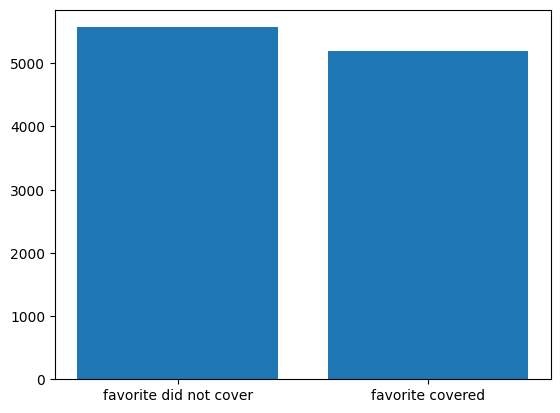

In [131]:
games['spread_favorite']
games.dropna(subset = ['spread_favorite','team_favorite_id'],inplace=True)
def covered(row):
    fav_covered = False
    if row['team_favorite_id'] == row['home_abrev']:
        point_diff = row['score_home']-row['score_away']
    else:
        point_diff = row['score_away'] - row['score_home']
    if point_diff > np.abs(row['spread_favorite']):
        return True
    elif point_diff < np.abs(row['spread_favorite']):
        return False
    else:
        return np.nan
games['favorite_covered'] = games.apply(covered,axis=1)
plt.bar(x=["favorite did not cover", "favorite covered"] ,height = games['favorite_covered'].value_counts())

It looks like the spread favorite only covers the spread about 5195 / (5195 + 5570) * 100 = 48.25824431% of the time! which means the books are approximately 1.75% off when calculating their spread probabilities. 
While this may look like a small percentage, it's enough to work with and give me hope that we can in fact beat the books.


Let's look at the relationship between the predicted ELO probabilities and the actual win rates of games

In [ ]:
plt.scatter(x=master_df['elo1_pre'],y=master_df['elo2_pre'],)

In [12]:
games['total'] = games['score_away'] + games['score_home']
highest_scoring = games.nlargest(n=250,columns='total')
highest_scoring.describe()

,schedule_date,schedule_season,score_home,score_away,spread_favorite,over_under_line,weather_temperature,weather_wind_mph,weather_humidity,over,gameID,total
count,250,250.000000,250.000000,250.000000,250.000000,250.000000,231.000000,230.000000,132.000000,250.0,2.500000e+02,250.0000
mean,2004-06-22 20:26:52.800000,2003.628000,41.720000,38.440000,-4.824000,45.224000,61.870130,5.460870,68.053030,1.0,9.326284e+18,80.1600
min,1979-09-02 00:00:00,1979.000000,21.000000,16.000000,-18.500000,32.000000,18.000000,0.000000,30.000000,1.0,3.643718e+16,74.0000
25%,1995-03-29 12:00:00,1994.250000,37.000000,34.000000,-6.500000,42.000000,53.000000,0.000000,57.000000,1.0,4.520647e+18,76.0000
50%,2006-04-26 12:00:00,2005.500000,41.000000,38.500000,-3.500000,45.000000,68.000000,6.000000,70.500000,1.0,9.540017e+18,79.0000
75%,2015-08-11 00:00:00,2014.750000,48.000000,44.000000,-3.000000,48.500000,72.000000,9.000000,79.000000,1.0,1.386452e+19,83.0000
max,2022-12-18 00:00:00,2022.000000,62.000000,59.000000,0.000000,63.500000,86.000000,18.000000,100.000000,1.0,1.842168e+19,106.0000
std,NaN,12.845139,7.717502,7.828893,3.276885,5.564321,14.311155,4.924384,15.072504,0.0,5.457133e+18,6.0889


Let's examine some of the highest ELO teams in the Superbowl era. By examining these teams we can try to look at similarities between them and see if we can identify common factors that indicate a team is on the rise. 

In [132]:
# first lets find the stronger opponent heading into a given matchup
sb_era_elo.loc[:,'stronger_team'] = sb_era_elo.loc[:,['elo1_pre','elo2_pre']].max(axis=1).copy()
#Now lets find the 250 strongest rated teams of the superbowl era and look at some summary statistics
strongest_250 = sb_era_elo.nlargest(250, columns='stronger_team')
strongest_250

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2,quality,importance,total_rating,gameID,stronger_team
13336,2008-02-03 00:00:00,2007.0,True,s,NYG,NE,1601.818,1849.484,0.193773,0.806227,...,231.310618,1631.332537,1788.082265,17.0,14.0,100.0,NaN,NaN,2008-02-03 00:00:00 NYG vs NE,1849.484
13335,2008-01-20 00:00:00,2007.0,False,c,NE,LAC,1839.663,1697.971,0.766708,0.233292,...,110.404801,1814.366226,1679.134742,21.0,12.0,100.0,NaN,NaN,2008-01-20 00:00:00 NE vs LAC,1839.663
13330,2008-01-12 00:00:00,2007.0,False,d,NE,JAX,1831.462,1638.157,0.815616,0.184384,...,149.670255,1806.390160,1636.995358,31.0,20.0,100.0,NaN,NaN,2008-01-12 00:00:00 NE vs JAX,1831.462
13310,2007-12-29 00:00:00,2007.0,False,NaN,NYG,NE,1539.477,1825.961,0.218409,0.781591,...,255.689563,1533.280110,1800.256592,35.0,38.0,98.0,NaN,NaN,2007-12-29 00:00:00 NYG vs NE,1825.961
13298,2007-12-23 00:00:00,2007.0,False,NaN,NE,MIA,1824.224,1315.198,0.964578,0.035422,...,36.726309,1795.514049,1304.289415,28.0,7.0,60.0,NaN,NaN,2007-12-23 00:00:00 NE vs MIA,1824.224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9204,1991-12-08 00:00:00,1991.0,False,NaN,ARI,WSH,1352.260,1721.546,0.147844,0.852156,...,175.129414,1344.161444,1712.341307,14.0,20.0,58.0,NaN,NaN,1991-12-08 00:00:00 ARI vs WSH,1721.546
13361,2008-09-14 00:00:00,2008.0,False,NaN,NYJ,NE,1460.740,1721.511,0.244725,0.755275,...,13.622139,1451.874090,1704.832598,10.0,19.0,45.0,NaN,NaN,2008-09-14 00:00:00 NYJ vs NE,1721.511
7576,1984-11-26 00:00:00,1984.0,False,NaN,MIA,NYJ,1721.472,1448.509,0.874952,0.125048,...,35.240467,1713.620218,1453.519538,28.0,17.0,90.0,NaN,NaN,1984-11-26 00:00:00 MIA vs NYJ,1721.472
5681,1976-01-04 00:00:00,1975.0,False,c,LAR,DAL,1721.455,1652.334,0.683967,0.316033,...,179.997140,1680.558686,1703.559126,7.0,37.0,100.0,NaN,NaN,1976-01-04 00:00:00 LAR vs DAL,1721.455


In [136]:
display(strongest_250.columns)
def find_stronger_qb(row):
    if row['stronger_team'] == row['elo1_pre']:
        return row['qbelo1_pre']
    else:
        return row['qbelo2_pre']
strongest_250['stronger_team_qb_elo'] = strongest_250.apply(find_stronger_qb,axis=1)
strongest_250['stronger_team_qb_elo']


Index(['date', 'season', 'neutral', 'playoff', 'team1', 'team2', 'elo1_pre',
       'elo2_pre', 'elo_prob1', 'elo_prob2', 'elo1_post', 'elo2_post',
       'qbelo1_pre', 'qbelo2_pre', 'qb1', 'qb2', 'qb1_value_pre',
       'qb2_value_pre', 'qb1_adj', 'qb2_adj', 'qbelo_prob1', 'qbelo_prob2',
       'qb1_game_value', 'qb2_game_value', 'qb1_value_post', 'qb2_value_post',
       'qbelo1_post', 'qbelo2_post', 'score1', 'score2', 'quality',
       'importance', 'total_rating', 'gameID', 'stronger_team'],
      dtype='object')

13336    1814.366226
13335    1806.390160
13330    1800.256592
13310    1795.514049
13298    1793.913721
            ...     
9204     1707.093469
13361    1675.232667
7576     1707.638352
5681     1727.907949
10199    1771.556278
Name: stronger_team_qb_elo, Length: 250, dtype: float64

<BarContainer object of 2 artists>

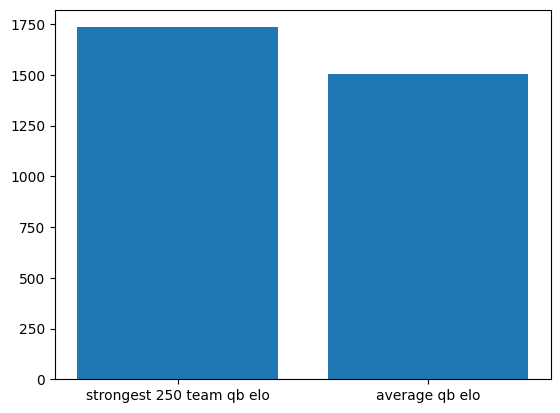

In [139]:
plt.bar(x=["strongest 250 team qb elo", "average qb elo"],height = [strongest_250['stronger_team_qb_elo'].mean(),(sb_era_elo['qbelo1_pre'].mean() + sb_era_elo['qbelo2_pre'].mean())/2])

These stats can give us a good idea of what an elite NFL team looks like. 

We can check out the correlation matrix for the superbowl era to give us a good idea of which variables are strongly related to each other

In [19]:
sb_era_elo.corr(numeric_only=True)

,season,neutral,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,qbelo1_pre,qbelo2_pre,...,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2,quality,importance,total_rating,stronger_team
season,1.000000,0.038872,0.032712,0.028070,0.007334,-0.007334,0.029652,0.029862,0.027427,0.023666,...,0.452962,0.451774,0.024820,0.025114,0.080755,0.106999,0.034826,0.018089,-0.012993,0.006191
neutral,0.038872,1.000000,0.084826,0.083578,-0.039827,0.039827,0.085251,0.079467,0.084992,0.082609,...,0.066565,0.061467,0.084841,0.078804,0.012352,0.013451,0.071569,0.035218,0.031396,0.090874
elo1_pre,0.032712,0.084826,1.000000,0.061971,0.685744,-0.685744,0.978431,0.058395,0.987043,0.057639,...,0.476438,0.013255,0.964710,0.054328,0.235189,-0.174316,0.687440,0.318225,0.535326,0.640473
elo2_pre,0.028070,0.083578,0.061971,1.000000,-0.673945,0.673945,0.063806,0.977432,0.059048,0.986506,...,0.033111,0.449599,0.059228,0.963081,-0.153995,0.211565,0.679247,0.452454,0.609669,0.618552
elo_prob1,0.007334,-0.039827,0.685744,-0.673945,1.000000,-1.000000,0.668490,-0.660139,0.678361,-0.666842,...,0.324082,-0.314942,0.661808,-0.652308,0.282795,-0.281131,0.020554,-0.062263,-0.019144,-0.014894
elo_prob2,-0.007334,0.039827,-0.685744,0.673945,-1.000000,1.000000,-0.668490,0.660139,-0.678361,0.666842,...,-0.324082,0.314942,-0.661808,0.652308,-0.282795,0.281131,-0.020554,0.062263,0.019144,0.014894
elo1_post,0.029652,0.085251,0.978431,0.063806,0.668490,-0.668490,1.000000,0.016606,0.966806,0.058421,...,0.489710,-0.014092,0.988414,0.010777,0.347673,-0.292022,0.675234,0.300735,0.515185,0.628813
elo2_post,0.029862,0.079467,0.058395,0.977432,-0.660139,0.660139,0.016606,1.000000,0.054483,0.965379,...,0.007257,0.468622,0.010265,0.987825,-0.271830,0.332149,0.661900,0.456017,0.609290,0.602958
qbelo1_pre,0.027427,0.084992,0.987043,0.059048,0.678361,-0.678361,0.966806,0.054483,1.000000,0.055366,...,0.459784,0.009052,0.977198,0.052258,0.237035,-0.175820,0.691193,0.327689,0.551292,0.629778
qbelo2_pre,0.023666,0.082609,0.057639,0.986506,-0.666842,0.666842,0.058421,0.965379,0.055366,1.000000,...,0.028504,0.432254,0.055653,0.976260,-0.156086,0.212300,0.681692,0.458611,0.620890,0.606745


#### Hypothesis
Games played in colder weather will tend to be lower scoring and therefore will not hit the over

In [141]:
#Let's test out our theory
freezing = games[games['weather_temperature'] <= 32]
freezing['over'].value_counts()

over
1    307
0    283
2      9
Name: count, dtype: int64

It doesn't look like it makes a difference, however there might be another explanation...

In [183]:
display(games['over_under_line'].describe())
display(freezing['over_under_line'].describe())

count    10998.000000
mean        42.266203
std          4.806823
min         28.000000
25%         38.500000
50%         42.000000
75%         45.000000
max         63.500000
Name: over_under_line, dtype: float64

count    597.000000
mean      40.273032
std        4.763183
min       28.000000
25%       37.000000
50%       40.000000
75%       43.000000
max       60.000000
Name: over_under_line, dtype: float64

It looks like bookmakers are already adjusting for the weather. We need to start thinking outside the box and look for factors they haven't though about yet if we want to get an edge. 

Lets look at games that hit the over vs games that did not hit the over

<Axes: xlabel='over_under_line', ylabel='total'>

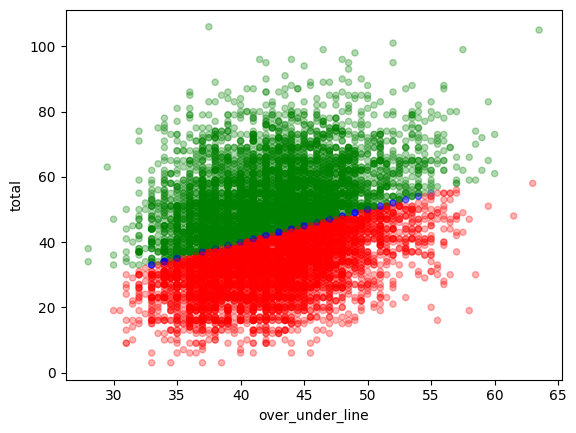

In [137]:

games['over'] = games['over'].map({0:'Red', 1:'Green', 2:'Blue'})
games.plot.scatter(x='over_under_line',y='total',c='over', alpha = .3)

This scatter plot shows us games that hit the over in green, games that hit the under in red, and games that pushed in blue, with total points on the y-axis, and the over under line on the x. This is a good way to visualize the data as we can clearly see where the over-under line is on the plot. 

# Building a Model

Onto the good stuff:
My approach for my model is will be:
- Build a Machine Learning model using the master dataframe that predicts the probability of a team winning a given game (classification)
- Build a second model that predicts point totals of a game (regression)
- potential independent variables for the models will be, Team ELOs, QB Elos, sportsbook odds, season record, momentum score (fraction of x previous games won), weather, injuries, and any other useful statitistics I can find
- Dependent variables for the model will be the winner/win probability for the first model, and the predicted score for each team in the second model
- Test the model using cross validation
- Use the predictions and probabilities from the model, along with the new odds from the Odds API to identify potential positive EV bets
- Test to see if our identified "positive EV" bets are actually profitable. 
- Repeat until we make a model that is profitable